**OCR**

Celem laborotarium było napisanie OCR, który będzie wykrywał tekst na zdjęciach, zapisany czcionką szeryfową (Times New Roman) i nieszeryfową (Arial)

In [39]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft2, ifft2
from PIL import Image, ImageDraw, ImageFont
import string
import os

***Przygotowanie danych***

Poniższe 3 funcje służą do wygenerowania obrazów png z tekstem zapisanym przekazaną jako argument czcionką

Funkcja generująca obrazki pojedyńczych liter. Generowane są zarówno małe jak i duże litery do odpowiednich katalogów odpowiednio arial_letters i times_letters. (W dalszej częsci skupię się na testowaniu tekstu zapisanego przy użyciu tylko małych liter)

In [ ]:
def letters_generator(font):
    output_folder = f"{font}_letters"

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    font_size = 100
    font = ImageFont.truetype(f"{font}.ttf", font_size)

    letters = string.ascii_letters
    cnt = 0
    for letter in letters:

        bbox = font.getmask(letter).getbbox()

        letter_width = bbox[2] - bbox[0]
        letter_height = bbox[3] - bbox[1]
        print((letter_height, bbox[3], bbox[1], cnt))

        image = Image.new("RGB", (letter_width + 2, font_size), "white")
        draw = ImageDraw.Draw(image)

        text_position = (1 - bbox[0], -17)

        draw.text(text_position, letter, fill="black", font=font)

        if cnt<26:
            image.save(os.path.join(output_folder, f"{letter}.png"))
        else:
            image.save(os.path.join(output_folder, f"{letter}_.png"))
        cnt+=1
    print("Images generated successfully.")

Poniżej znajduje się tekst służący do przetestowania działania programu. Charakteryzuje się on tym, że posiada każdą literkę angielskiego alfabetu.

In [ ]:
text1 = """a quick brown fox jumps over the lazy dog, while zealous
cats quietly observe, perhaps meditating, with a hint of joyful exuberance,
kindly leaping amidst nocturnal breezes, gracefully humming in jubilant
whispers, venturing with zeal across distant landscapes, exploring forests
rich with vibrant foliage"""

Funkcja generująca obraz na którym znajduje się przekazany jako argument ```text``` tekst zapisany przekazaną jako argument ```font``` czcionką

In [ ]:
def generate_png_text(text, font):
    image_width = 3500
    image_height = 550
    background_color = "white"
    image = Image.new("RGB", (image_width, image_height), background_color)
    
    draw = ImageDraw.Draw(image)

    font_size = 100
    font_family = f"{font}.ttf"

    font = ImageFont.truetype(font_family, font_size)

    text_color = "black"
    text_position = (25, 25)

    draw.text(text_position, text, fill=text_color, font=font)
    image.save(f"{font}_texts/every_letter_text.png")

Funkcja zwracająca słownik, gdzie argumentem jest litera, a wartoscia jej szerokosć.

In [88]:
def letters_width(letters, font):
    widths_map = dict()
    for letter in letters:
        try:
            image = Image.new("RGB", (1, 1), (255, 255, 255))
            draw = ImageDraw.Draw(image)
            font = ImageFont.truetype(f"{font}.ttf", 100)
            bbox = draw.textbbox((0, 0), letter, font=font)
            width = bbox[2] - bbox[0]
            widths_map[letter] = width
        except Exception as e:
            print(f"Error processing letter '{letter}': {e}")

    return widths_map

Wszystkie powyższe funkcję zapewniały dane na których będzie działał algorytm.

***Znajdowanie liter na obrazie***

Funkcja ```image_analyze``` znajduje miejsca na obrazie ```image``` w których korelacja obrazu ```pattern``` (z owym wykrywanym miejscem) jest większa lub równa argumentowi ```threshold```. Następnie aktualizowane są tablice ```filtered_y```, ```filtered_x``` w których zapisywane są już zajęte miejsca przez wczesniej wyszukane litery (uwzględniana jest szerokosć liter). Wykryta litera jest dodawana do ```dp``` będącą tablicą wszystkich wykrytych dotychczas liter tylko wtedy, gdy korelacja jest odpowiednio duża i na danym miejscu nie została wykryta wczesniej żadna inna litera. Dla każdej litery generowany jest obraz z zanaczonymi miejscami wystąpień.

In [37]:
def image_analyze(dp, letter, image, pattern, cut, convert, filtered_y, filtered_x, font,  print_res=False, width=30):

    pattern = np.array(Image.open(pattern).convert('L'))
    
    if convert:
        image = 255 - image
        pattern = 255 - pattern

    corr = np.real(ifft2(fft2(image) * fft2(np.rot90(pattern, 2), image.shape)))

    threshold = cut * np.max(corr)
    peaks = np.where(corr >= threshold)
    
    y = peaks[0]
    x = peaks[1]

    for i in range(len(y)):
        unique = True
        for j in range(len(filtered_x)):
            if (filtered_x[j][0] <= x[i] <= filtered_x[j][1] or filtered_x[j][0] <= x[i]-width <= filtered_x[j][1]) and abs(y[i] - filtered_y[j]) <= 30:
                unique = False
                break
                
                
        if unique:
            filtered_y.append(y[i])
            if font == "arial":
                if letter in "jh":
                    filtered_x.append((x[i]-width, x[i]))
                elif letter in "l":
                    filtered_x.append((x[i]-width+5, x[i]))
                else:
                    filtered_x.append((x[i]-width+11, x[i]-11))

            elif font == "times":
                filtered_x.append((x[i]-width+18, x[i]-18))
                
            dp.append((y[i], x[i], letter))

    if print_res:
        print(dp)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(corr, cmap='gray')
    plt.title('Correlation Map')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.title('Detected Points')
    plt.plot(peaks[1], peaks[0], 'ro', markersize=5)
    plt.show()
    
    num_occurrences = len(peaks[0])
    print("Number of occurrences:", num_occurrences)


Funkcja ```read_text``` odpowiada za ułożenie wykrytych liter w słowa. Aby mogło to zostac poprawnie zrobione, litery wykrywane są w specjalnej kolejnosci, od tych wykrywanych najlepiej (tylko w odpowiednich miejscach) po te wykrywane nie tylko na swoich prawidłowych miejscach, ale także nadprogramowo w miejscach innych liter. Przydatne podczas podziału na słowa są szerokosci liter, aby dobrze oznaczyć zajmowane przez dane litery miejsca w ```filtered_y``` oraz ```filtered_y```. Początkowo wykryte litery dzielone są na linie, w których się znajdują, następnie są sortowane (najpierw po numerze linii, a potem po miejscu w danej linii). Tak posortowane litery rozdzielane są na słowa. Następuje to poprzez wykrywanie większej odległosci miedzy literami niż zazwyczaj. Przeczytane słowa zwracane są w tablicy.

In [34]:
def read_text(filename, font):
    letters = "aeyzqgumtvpsckdbrfxowjhnli"
    widths_map = {'a': 56, 'b': 56, 'c': 50, 'd': 56, 'e': 56, 'f': 32, 'g': 56, 'h': 56, 'i': 22, 'j': 27, 'k': 50, 'l': 22, 'm': 83, 'n': 56, 'o': 56, 'p': 56, 'q': 56, 'r': 35, 's': 50, 't': 28, 'u': 56, 'v': 50, 'w': 72, 'x': 50, 'y': 50, 'z': 50, 'A': 68, 'B': 67, 'C': 72, 'D': 72, 'E': 67, 'F': 61, 'G': 78, 'H': 72, 'I': 28, 'J': 50, 'K': 67, 'L': 56, 'M': 83, 'N': 72, 'O': 78, 'P': 67, 'Q': 78, 'R': 72, 'S': 67, 'T': 61, 'U': 72, 'W': 94, 'X': 67, 'Y': 67, 'Z': 61}

    filtered_x = []
    filtered_y = []
    dp = []
    image = np.array(Image.open(filename).convert('L'))
    for l in letters:
        print("result for " + l)
        corr = 0.99
        
        if ord("A") <= ord(l) <= ord("Z"):
            letter_code = f"{l}_"
            
        else:
            letter_code = l
            
        image_analyze(dp, l, image, f"{font}_letters/{letter_code}.png", corr, True, filtered_y, filtered_x, font, width=widths_map[l])
        
        
    line = 0
    last = 0
    result = []
    dp.sort()
    for y, x, elem in dp:
        if abs(y-last) > 30:
            line+=1
        last = y
        result.append((line, x-widths_map[elem], elem))
    result.sort()
    
    dist = 15
    
    if font == "arial":
        dist = 15
    elif font == "times":
        dist = 12
    
    words = []  
    word = ""
    last_y = 0
    last_x = 0
    prev = 0
    for y, x, elem in result:
        if y != last_y or abs(x-last_x) - prev > dist:
            words.append(word)
            word = ""
        prev = widths_map[elem]
        last_y = y
        last_x = x
        word += elem
        
    words.append(word)
    return words
        

***Wyniki czcionka Arial***

result for a


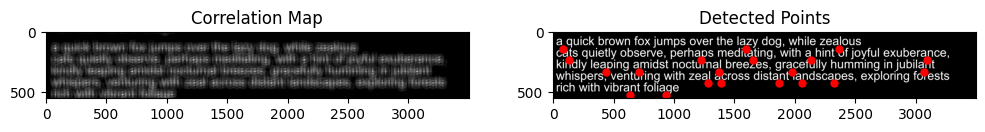

Number of occurrences: 20
result for e


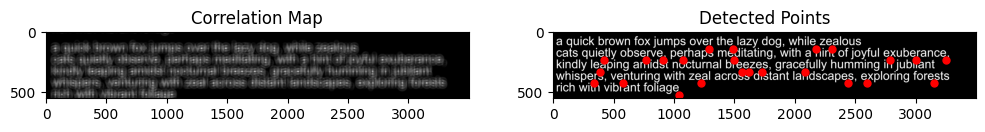

Number of occurrences: 24
result for y


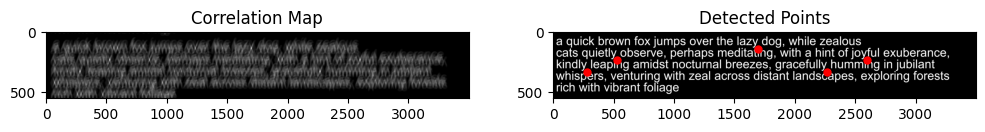

Number of occurrences: 5
result for z


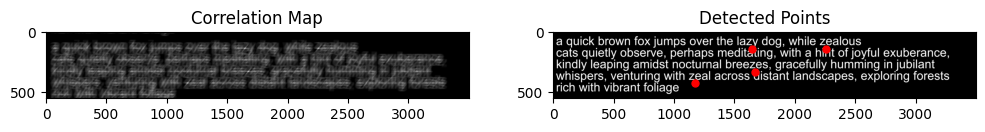

Number of occurrences: 4
result for q


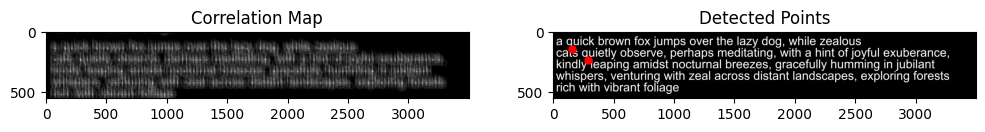

Number of occurrences: 2
result for g


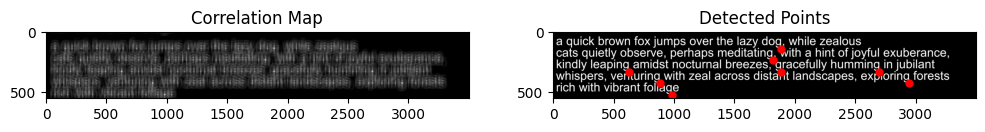

Number of occurrences: 8
result for u


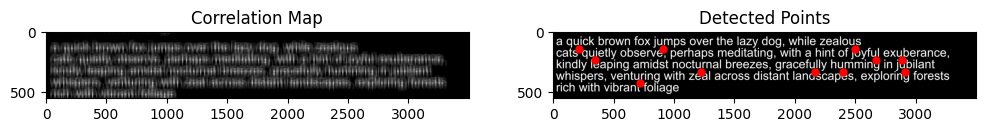

Number of occurrences: 11
result for m


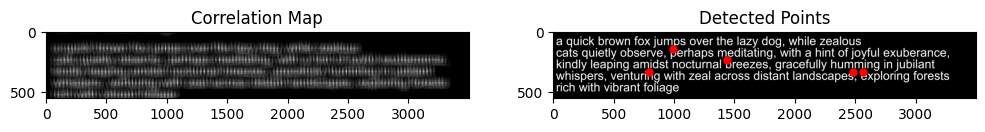

Number of occurrences: 5
result for t


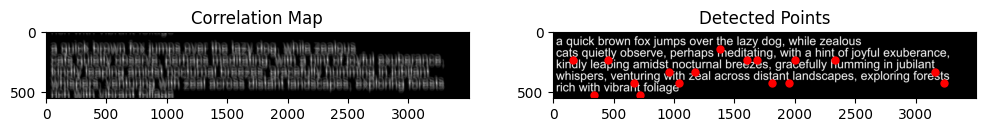

Number of occurrences: 17
result for v


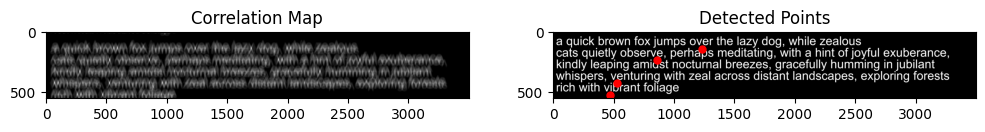

Number of occurrences: 4
result for p


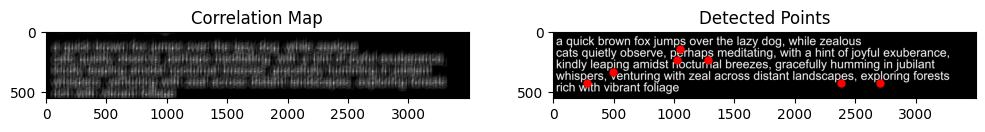

Number of occurrences: 7
result for s


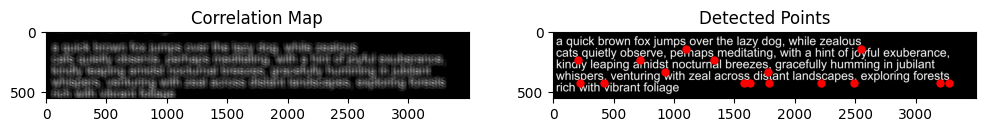

Number of occurrences: 16
result for c


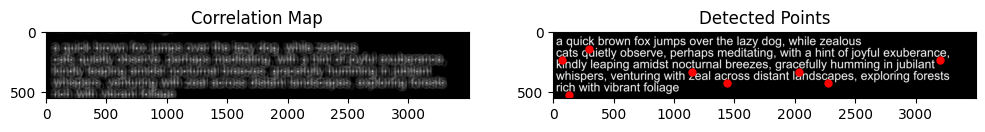

Number of occurrences: 8
result for k


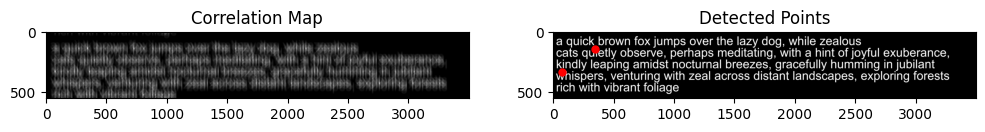

Number of occurrences: 2
result for d


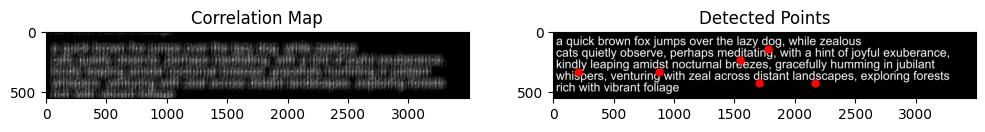

Number of occurrences: 6
result for b


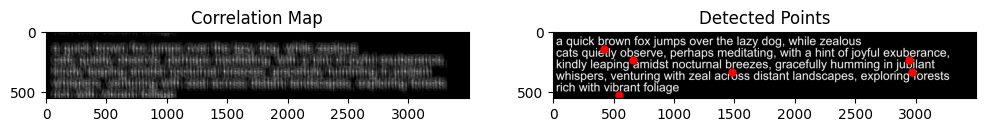

Number of occurrences: 6
result for r


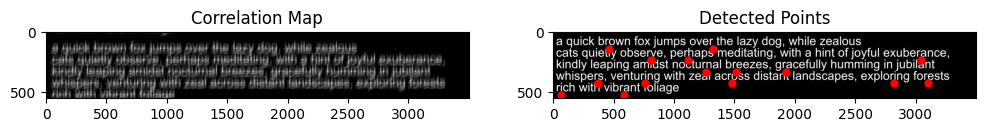

Number of occurrences: 15
result for f


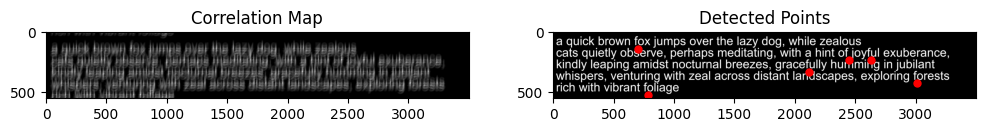

Number of occurrences: 6
result for x


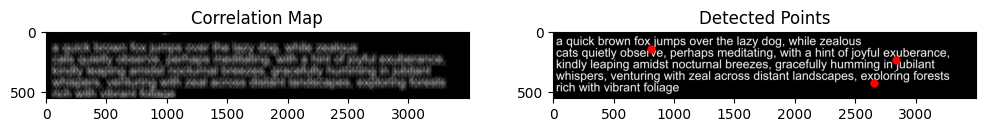

Number of occurrences: 3
result for o


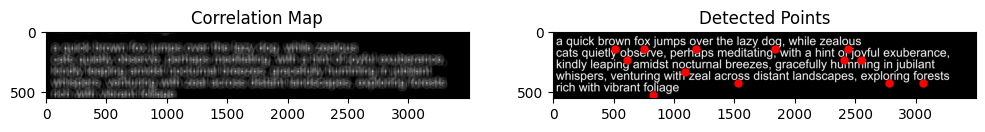

Number of occurrences: 13
result for w


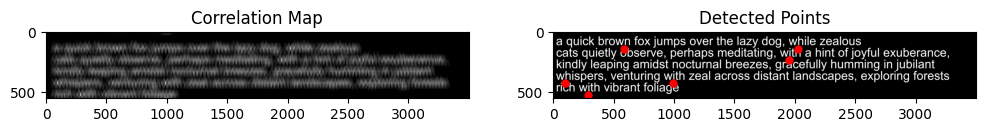

Number of occurrences: 6
result for j


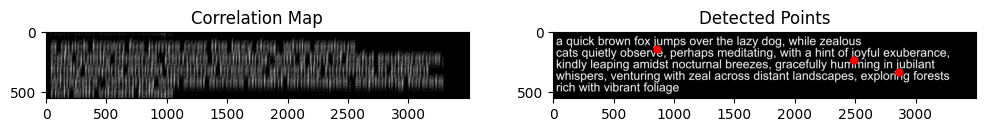

Number of occurrences: 3
result for h


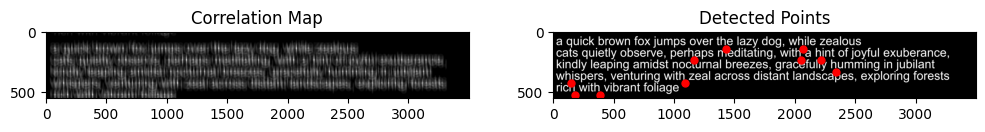

Number of occurrences: 10
result for n


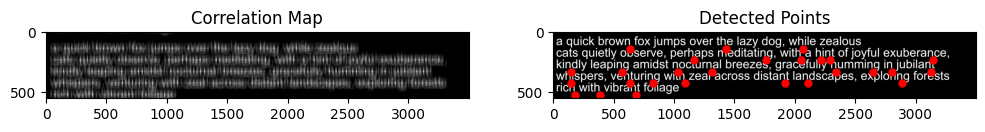

Number of occurrences: 27
result for l


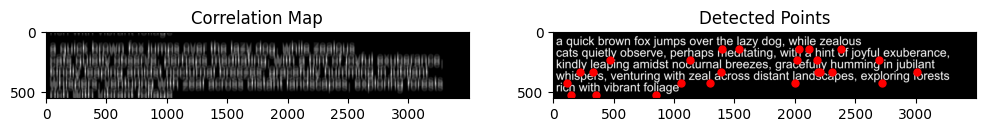

Number of occurrences: 25
result for i


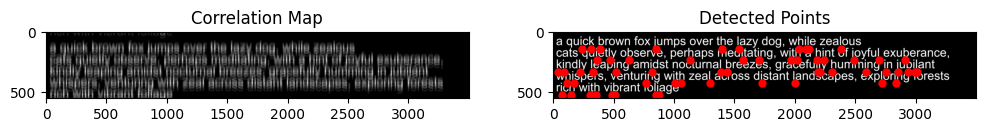

Number of occurrences: 58
['', 'a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', 'while', 'zealous', 'cats', 'quietly', 'observe', 'perhaps', 'meditating', 'with', 'a', 'hint', 'of', 'joy', 'ul', 'exuberance', 'kindly', 'leaping', 'amidst', 'nocturnal', 'breezes', 'grace', 'ul', 'y', 'humming', 'in', 'jubilant', 'whispers', 'venturing', 'with', 'zeal', 'across', 'distant', 'landscapes', 'exploring', 'forests', 'rich', 'with', 'vibrant', 'fol', 'age']


In [120]:
print(read_text("arial_texts/every_letter_text.png", "arial"))

Algorytm większosc liter przeczytał prawidłowo oraz przyjąta przeze mnie filtracja dała zadowalające wyniki, tylko niektóre litery zostały pominięte rozdzielając błędnie słowa (można by delikatnie obniżyć surowosc filtracji, jednak wtedy w wielu miejscach pojawiają się zwielokrotnione litery).

*Poprawnie wykryto 41/44 słowa*
Poprawnosc: 93%

***Wyniki czcionka Times New Roman***

result for a


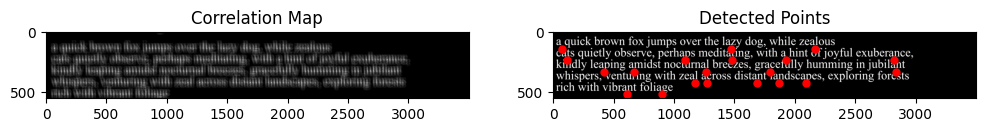

Number of occurrences: 20
result for e


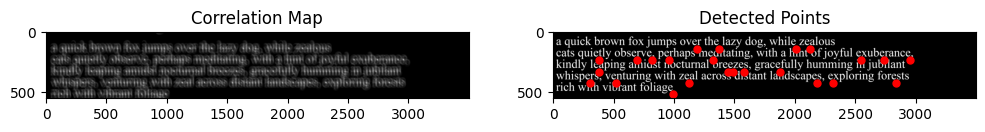

Number of occurrences: 24
result for y


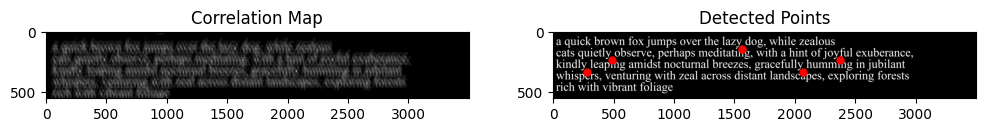

Number of occurrences: 5
result for z


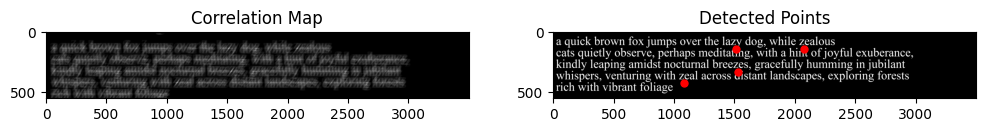

Number of occurrences: 4
result for q


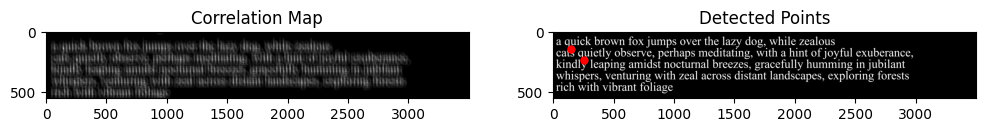

Number of occurrences: 2
result for g


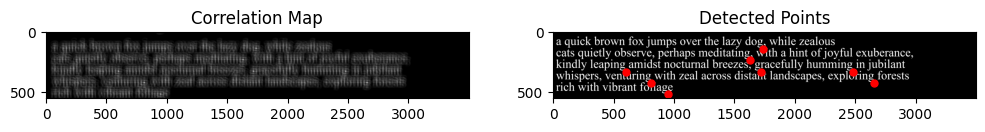

Number of occurrences: 8
result for u


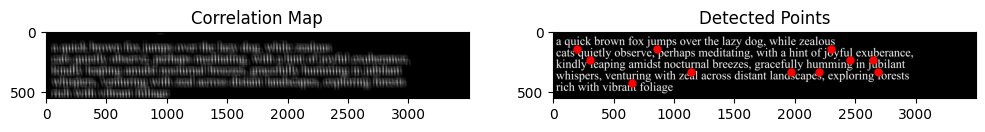

Number of occurrences: 11
result for m


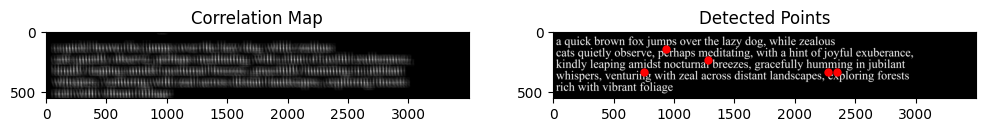

Number of occurrences: 5
result for t


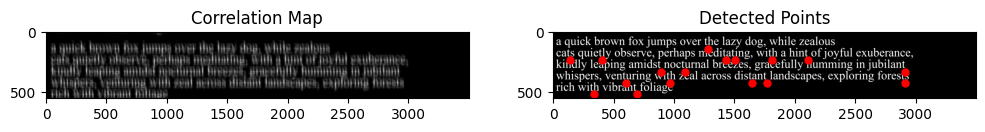

Number of occurrences: 17
result for v


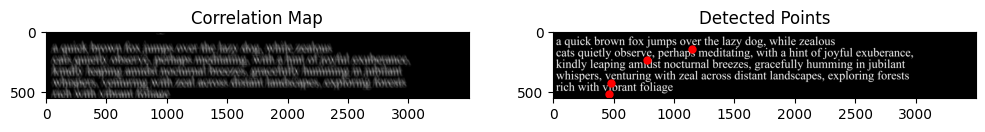

Number of occurrences: 4
result for p


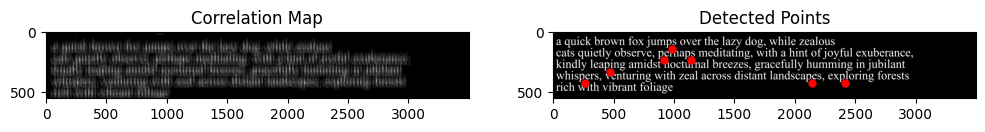

Number of occurrences: 7
result for s


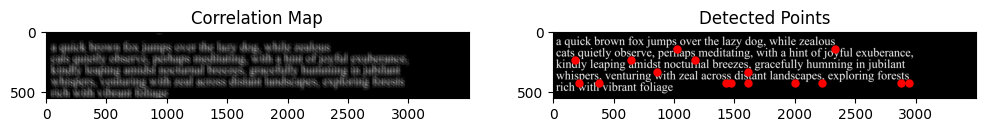

Number of occurrences: 16
result for c


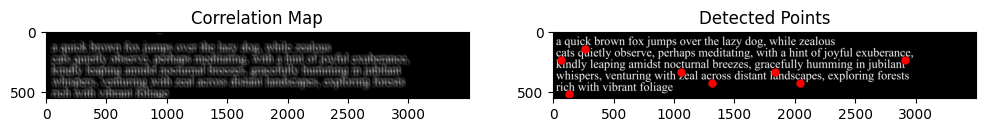

Number of occurrences: 8
result for k


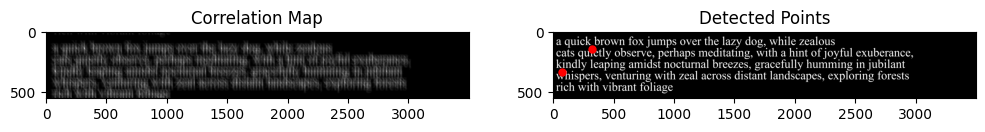

Number of occurrences: 2
result for d


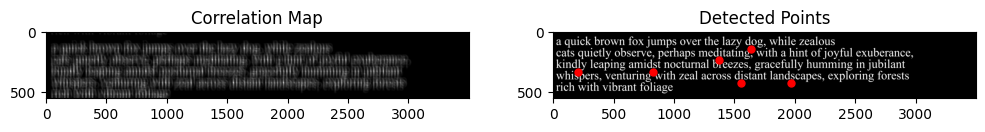

Number of occurrences: 6
result for b


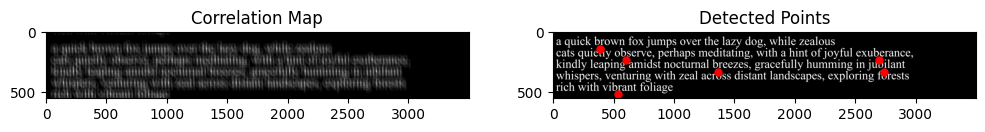

Number of occurrences: 6
result for r


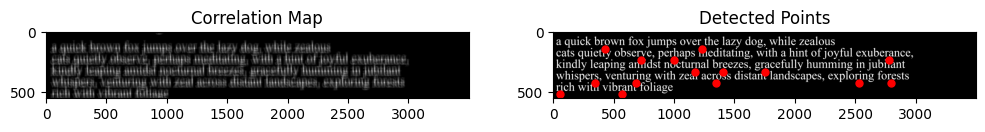

Number of occurrences: 15
result for f


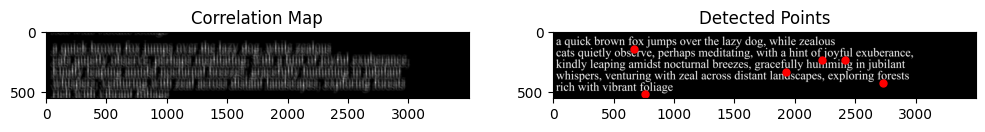

Number of occurrences: 6
result for x


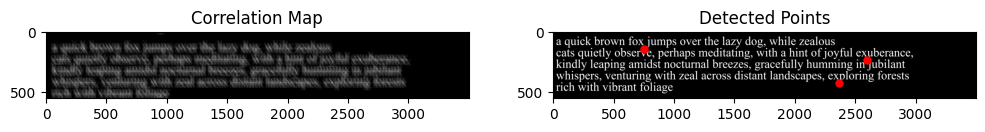

Number of occurrences: 3
result for o


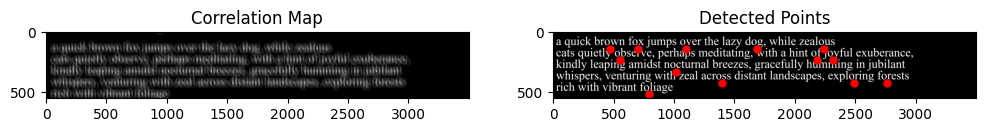

Number of occurrences: 13
result for w


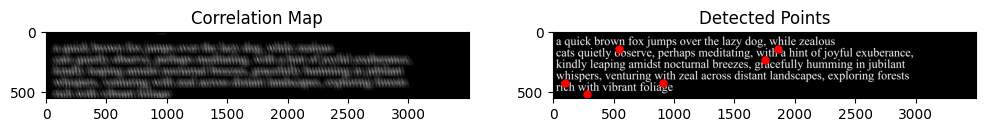

Number of occurrences: 6
result for j


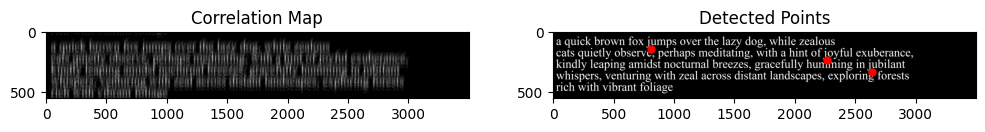

Number of occurrences: 3
result for h


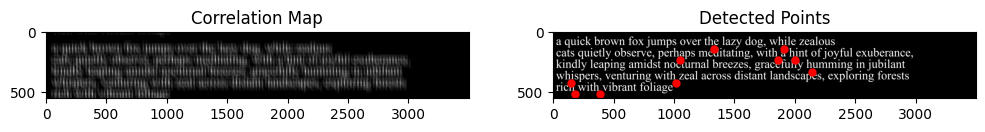

Number of occurrences: 10
result for n


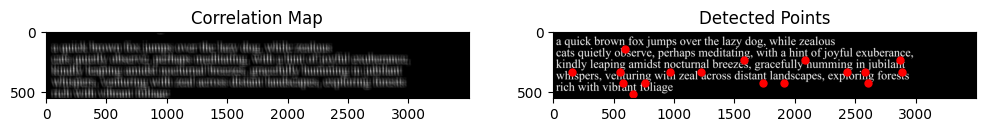

Number of occurrences: 17
result for l


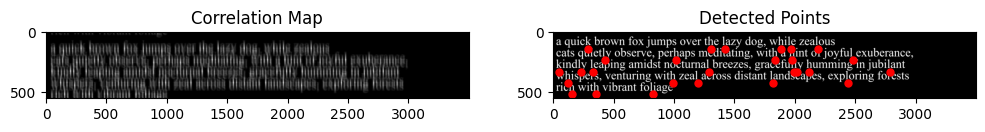

Number of occurrences: 27
result for i


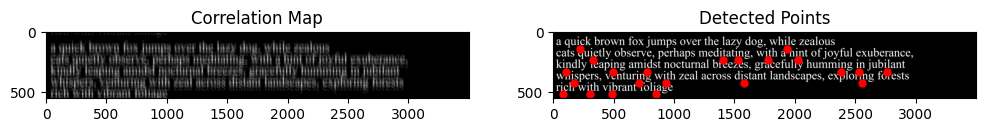

Number of occurrences: 22
['', 'a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', 'while', 'zealous', 'cats', 'quietly', 'observe', 'perhaps', 'meditating', 'with', 'a', 'hint', 'o', 'f', 'joyful', 'exuberance', 'kindly', 'leaping', 'amidst', 'nocturnal', 'breezes', 'grace', 'fully', 'humming', 'in', 'jubilant', 'whispers', 'venturing', 'with', 'zeal', 'across', 'distant', 'landscapes', 'exploring', 'forests', 'rich', 'with', 'vibrant', 'foliage']


In [38]:
print(read_text("times_texts/every_letter_text.png", "times"))

Tylko w dwóch miejscach algorytm rodzielił słowo nadprogamowo. W porównaniu do czcionki nieszeryfowej ```Arial``` algorytm działając na czcionce szeryfowej ```Times New Roman``` poradził sobie lepiej, co może być uznane za zaskakujące.
Poprawnie wykryto 42/44 słowa
Poprawnosc: 95%

***Podsumowanie***

Program zadowalająco zczytuje tekst zawarty na obrazach, jednak testowane przypadki są laboratoryjną wersją działania prawdziwych OCR-ów. Owy algorytm nie sprawdzi się dobrze w przypadku zdjęcia zrobionego w słabych warunkach swietlnych, nieostrego czy też pod kątem. Do tego celu należało by uzyc bardziej skomplikowanego programu np.opartego na uczeniu maszynowym. Jednak otrzymane przezemnie wyniki są dla mnie satysfakcjonujące i zadowalające.